<a href="https://colab.research.google.com/github/Muhammad-Shah/ITSOLERA-internship-TASK-1/blob/master/Sentiment_Analysis_1_(90_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
%cd /content/drive/MyDrive/MODELS

/content/drive/MyDrive/MODELS


In [78]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Installation and Setup

In [1]:
!pip install --quiet datasets evaluate transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is

In [ ]:
# from google.colab import files

# files.upload()

# ! mkdir ~/.kaggle

# ! cp kaggle.json ~/.kaggle/

# ! chmod 600 ~/.kaggle/kaggle.json

# file_name = 'jigsaw-toxic-comment-classification-challenge'

# ! kaggle competitions download -c {file_name} -p /content/sample_data

# ! unzip /content/sample_data/{file_name}.zip -d /content/sample_data/data

# ! rm /content/sample_data/{file_name}.zip

In [2]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification, Trainer, BertTokenizer, BertForSequenceClassification
import evaluate
import numpy as np
import re
import html
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 2. Data Preparation

In [3]:
imdb_reviews_dataset = load_dataset("stanfordnlp/imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
imdb_reviews_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
count = 0
for row in imdb_reviews_dataset['train'].shuffle(seed=42):
    print(row)
    count += 1
    if count >= 10:
        break

{'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1}
{'text': 'This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stub your t

In [58]:
from datasets import concatenate_datasets

# Concatenate train and test datasets
dataset = concatenate_datasets([imdb_reviews_dataset['train'], imdb_reviews_dataset['test']])

# Split the dataset into training and test sets
dataset = dataset.train_test_split(test_size=0.05, shuffle=True)


imdb_train_dataset = dataset['train']
imdb_test_dataset = dataset['test']
# Check the resulting dataset splits
print(f"Training set: {len(imdb_train_dataset)} samples")
print(f"Test set: {len(imdb_test_dataset)} samples")

# Output the dataset splits
print(imdb_train_dataset)
print(imdb_test_dataset)

Training set: 47500 samples
Test set: 2500 samples
Dataset({
    features: ['text', 'label'],
    num_rows: 47500
})
Dataset({
    features: ['text', 'label'],
    num_rows: 2500
})


## 2. Data Exploration

In [7]:
features = imdb_reviews_dataset['test'].features
print(features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}


In [8]:
# Function to count the number of reviews with length less than 100
def count_short_reviews(dataset, split='train', max_length=512):
    reviews = dataset[split]['text']
    short_reviews_count = sum(1 for review in reviews if len(review) < max_length)
    return short_reviews_count

# Get the count of short reviews in the training set
short_reviews_count = count_short_reviews(dataset, split='test')
print(f"Number of reviews with length less than 100 characters: {short_reviews_count}")

Number of reviews with length less than 100 characters: 253


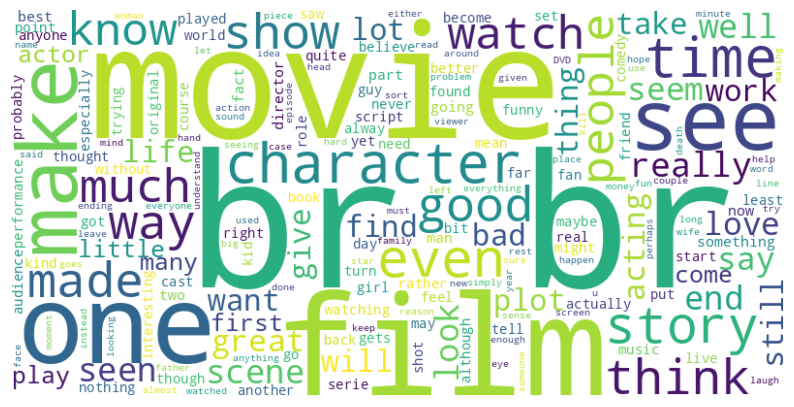

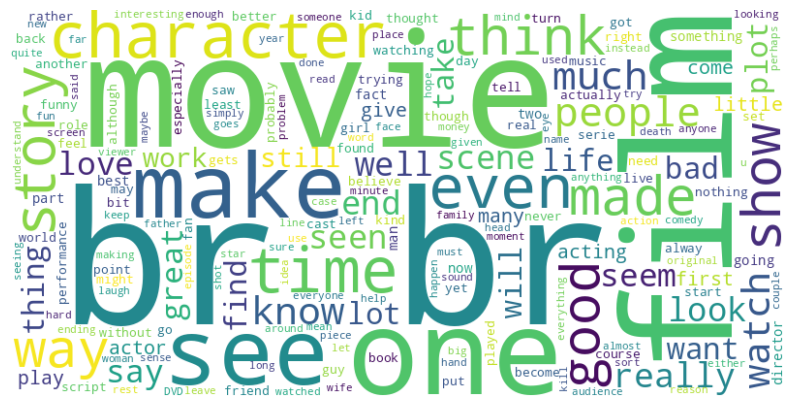

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming imdb_train_dataset is already filtered using filter_words_by_frequency

# Concatenate all texts into a single string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming imdb_train_dataset is already filtered using filter_words_by_frequency

# Flatten the list of lists into a single list of words
all_words = [text for example in imdb_train_dataset['text'] for text in example.split()]

# Join all words into a single string separated by spaces
all_texts = ' '.join(all_words)



# Generate WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_texts)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Generate WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_texts)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
# Access the words shown in the word cloud
words_shown = wordcloud.words_

# Print or use words_shown as needed
print("Words shown in the word cloud:", words_shown.keys())

Words shown in the word cloud: dict_keys(['br br', 'movie', 'film', 'one', 'see', 'make', 'character', 'time', 'even', 'story', 'think', 'way', 'made', 'show', 'good', 'people', 'much', 'know', 'watch', 'really', 'scene', 'end', 'seen', 'well', 'look', 'say', 'seem', 'love', 'great', 'life', 'thing', 'bad', 'will', 'want', 'plot', 'take', 'lot', 'find', 'still', 'work', 'acting', 'give', 'little', 'actor', 'come', 'many', 'play', 'first', 'something', 'now', 'part', 'going', 'man', 'fact', 'director', 'best', 'two', 'go', 'though', 'thought', 'actually', 'funny', 'watching', 'role', 'nothing', 'feel', 'back', 'kind', 'guy', 'got', 'real', 'never', 'saw', 'better', 'world', 'set', 'point', 'may', 'least', 'right', 'script', 'believe', 'performance', 'another', 'girl', 'friend', 'start', 'serie', 'course', 'need', 'book', 'found', 'played', 'kid', 'become', 'live', 'bit', 'put', 'day', 'alway', 'probably', 'although', 'music', 'turn', 'tell', 'fan', 'yet', 'trying', 'gets', 'without', 'e

In [33]:
# Extracting labels and mapping
labels = features['label'].names
id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

# Displaying id to label mapping
print(id2label)

{0: 'neg', 1: 'pos'}


In [59]:
checkpoint = 'prajjwal1/bert-tiny'
# Load the BERT-Tiny tokenizer and model
tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preprocessing

### Cleaning

In [60]:
contractions = {
        "i'm": "i am", "you're": "you are", "he's": "he is", "she's": "she is",
        "it's": "it is", "we're": "we are", "they're": "they are", "i've": "i have",
        "you've": "you have", "we've": "we have", "they've": "they have", "i'd": "i would",
        "you'd": "you would", "he'd": "he would", "she'd": "she would", "we'd": "we would",
        "they'd": "they would", "i'll": "i will", "you'll": "you will", "he'll": "he will",
        "she'll": "she will", "we'll": "we will", "they'll": "they will", "can't": "cannot",
        "won't": "will not", "don't": "do not", "doesn't": "does not", "didn't": "did not",
        "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
        "haven't": "have not", "hasn't": "has not", "hadn't": "had not", "shouldn't": "should not",
        "wouldn't": "would not", "couldn't": "could not", "mightn't": "might not", "mustn't": "must not"
    }

stop_words = [
    "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",  "movie", "movies", "film",
    "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can't", "cannot", "could", 'made', 'character', 'woman',
    "couldn't", "did", "didn't", "do", "does", "doesn't", "doing", "don't", "down", "during", "each", "few", "for", 'wife', 'guy', 'let', 'book',
    "from", "further", "had", "hadn't", "has", "hasn't", "have", "haven't", "having", "he", "he'd", "he'll", "he's", 'friend', 'watch', 'man', 'time',
    "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", 'say', 'sence', 'way', 'thing', 'world',
    "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "mustn't",
    "my", "myself", "of", "off", "on", "once", "only", "or", "other", "ought", "our", "ours",
    "ourselves", "out", "over", "own", "same", "shan't", "she", "she'd", "she'll", "she's", "should", "shouldn't",
    "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there",
    "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too",
    "under", "until", "up", "very", "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were", "weren't",
    "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's",
    "with", "won't", "would", "wouldn't", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself",
    "yourselves"
    'movie', 'film', 'one', 'see', 'make', 'character', 'time', 'even', 'story', 'think', 'way', 'made', 'show',
    'people', 'know', 'watch', 'scene', 'end', 'seen', 'well', 'look', 'say', 'seem',
    'life', 'thing', 'will', 'want', 'plot', 'take', 'lot', 'find', 'still', 'work', 'give', 'little',
    'actor', 'come', 'many', 'play', 'first', 'something', 'now', 'part', 'going', 'man', 'fact', 'director',
    'two', 'go', 'though', 'thought', 'actually', 'funny', 'watching', 'role', 'nothing', 'feel', 'back', 'kind', 'guy',
    'got', 'saw', 'world', 'set', 'point', 'may', 'script', 'believe', 'performance',
    'another', 'girl', 'friend', 'start', 'serie', 'course', 'need', 'book', 'found', 'played', 'kid', 'become', 'live', 'bit',
    'put', 'day', 'alway', 'probably', 'although', 'music', 'turn', 'tell', 'fan', 'yet', 'trying', 'gets', 'without',
    'especially', 'rather', 'cast', 'might', 'original', 'shot', 'anyone', 'audience', 'maybe',
    'quite', 'far', 'everything', 'almost', 'use', 'watched', 'sure', 'must', 'u', 'someone', 'anything', 'making', 'instead',
    'enough', 'done', 'new', 'reason', 'family', 'ending', 'help', 'idea', 'let', 'keep', 'star', 'goes',
    'minute', 'DVD', 'line', 'read', 'long', 'woman', 'looking', 'money', 'everyone', 'around', 'used', 'moment', 'hard',
    'action', 'laugh', 'left', 'mind', 'problem', 'wife', 'rest',
    'father', 'episode', 'simply', 'happen', 'head', 'viewer', 'sense', 'sort', 'screen', 'face', 'death', 'year', 'place',
    'name', 'try', 'given', 'seeing', 'couple', 'understand', 'big', 'perhaps', 'leave', 'eye', 'case', 'word', 'kill', 'piece',
    'hope', 'either', 'sound', 'hand']

def preprocess_function(examples):
    """
    Preprocesses a list of examples by performing several text transformations.

    Args:
        examples (dict): A dictionary containing a list of texts.

    Returns:
        dict: The preprocessed dictionary with the list of texts.

    Preprocessing steps:
        1. Unescape HTML entities.
        2. Replace newline characters, carriage return characters, and tab characters with spaces.
        3. Convert text to lowercase and remove backslashes.
        4. Replace common contractions.
        5. Remove URLs, mentions, and hashtags.
        6. Remove words containing digits.
        7. Remove HTML tags.
        8. Remove any non-alphanumeric characters.
    """
    # Unescape HTML entities
    examples['text'] = [html.unescape(x) for x in examples['text']]
    # Replace newline characters, carriage return characters, and tab characters with spaces
    examples['text'] = [x.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ') for x in examples['text']]

    # Convert text to lowercase and remove backslashes
    examples['text'] = [x.lower().replace('\\', '') for x in examples['text']]

    # Remove stop words
    # examples['text'] = [' '.join([word for word in x.split() if word not in stop_words]) for x in examples['text']]


    # Replace common contractions
    examples['text'] = [' '.join([contractions.get(word, word) for word in x.split()]) for x in examples['text']]

    # Remove URLs, mentions, and hashtags
    examples['text'] = [re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE) for x in examples['text']]
    examples['text'] = [re.sub(r'\@\w+|\#', '', x, flags=re.MULTILINE) for x in examples['text']]

    # Remove words containing digits
    examples['text'] = [re.sub(r'\w*\d\w*', '', x, flags=re.MULTILINE) for x in examples['text']]

    # Remove HTML tags
    examples['text'] = [re.sub(r'<.*?>', ' ', x, flags=re.MULTILINE) for x in examples['text']]

    # Remove any non-alphanumeric characters
    examples['text'] = [re.sub(r'[^A-Za-z0-9\s]+', '', x, flags=re.MULTILINE) for x in examples['text']]

    return examples

In [61]:
train_dataset_tokenized = imdb_train_dataset.map(preprocess_function, batched=True)
# valid_dataset_tokenized = imdb_valid_dataset.map(preprocess_function, batched=True, remove_columns=['text'])
test_dataset_tokenized = imdb_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/47500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [62]:
train_dataset_tokenized[0]

{'text': '  i have seen this movie many times at least a dozen but unfortunatly not recently however etched in my memory never to leave me is a scene in which mickey rooney killer mears knows that he is to be executed and it is getting close to the moment of truth he dances and cries and laughs he vacillates from hesteria to euphoria and runs the gambit of ever emotion never have i seen such a brilliant performance by any actor living or dead past or present it was then i know for sure that mickey rooney yes andy hardy was and is a actor of great genius however i kept it my opinion to myself for years thinking surely i must be alone in this viewpoint about  years or so after i saw this film for the last time on television i chanced to read the old q  a section of the los angeles times the question was posed to lawrence olivier and the question was mr olivier you are considered one of the greatest actors of all time whom then do you consider to be among the greatest actors his answer wa

### Data Augmentation

In [63]:
import random
import numpy as np
from typing import List, Tuple

# Define your data augmentation function
def data_augmentation(texts: List[str], labels: List[int], augmentation_prob=0.5) -> Tuple[List[str], List[int]]:
    augmented_texts = []
    augmented_labels = []
    for text, label in zip(texts, labels):
        if random.random() < augmentation_prob:
            if label == 1:  # Positive sentiment
                technique = random.choice(["insertion", "synonymreplacement", "intensification"])
            else:  # Negative sentiment
                technique = random.choice(["insertion", "synonymreplacement", "negation"])

            if technique == "insertion":
                # Insert a random sentiment word
                sentiment_words = {"positive": ["amazing", "great", 'love', "fantastic"], "negative": ["terrible", "awful", 'hate', "horrible"]}
                text = f"I {random.choice(sentiment_words['positive' if label == 1 else 'negative'])} {text}"

            elif technique == "synonymreplacement":
                # Replace a random word with its synonym
                synonyms = {"good": ["great", "excellent", "fantastic"], "bad": ["terrible", "awful", 'suck', "horrible"]}
                words = text.split()
                for i, word in enumerate(words):
                    if word in synonyms:
                        words[i] = random.choice(synonyms[word])
                text = " ".join(words)

            elif technique == "intensification" and label == 1:
                # Intensify the positive sentiment
                intensifiers = ["very", "extremely", "highly"]
                text = f"I {random.choice(intensifiers)} {text}"

            elif technique == "negation" and label == 0:
                # Add a negation to the negative text
                negations = ["not", "no", "none", "fuck", "f**k"]
                text = f"{random.choice(negations)} {text}"

        augmented_texts.append(text)
        augmented_labels.append(label)

    return augmented_texts, augmented_labels

# Apply data augmentation
def preprocess_with_augmentation(examples):
    texts = examples['text']
    labels = examples['label']
    texts, labels = data_augmentation(texts, labels)  # Apply data augmentation
    return {'text': texts, 'label': labels}

In [64]:
train_dataset_tokenized = train_dataset_tokenized.map(preprocess_with_augmentation, batched=True)

Map:   0%|          | 0/47500 [00:00<?, ? examples/s]

In [65]:
train_dataset_tokenized

Dataset({
    features: ['text', 'label'],
    num_rows: 47500
})

## 5. Tokenization

In [66]:
train_dataset_tokenized = train_dataset_tokenized.map(lambda examples: tokenizer(examples['text'], truncation=True, max_length=512), batched=True)
test_dataset_tokenized = test_dataset_tokenized.map(lambda examples: tokenizer(examples['text'], truncation=True, max_length=512), batched=True)

Map:   0%|          | 0/47500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Examining one example after preprocessing

In [67]:
tokenizer.decode(train_dataset_tokenized[1]['input_ids'])

'[CLS] i horrible this derivative erotic thriller remains watchable most of the way mainly because a viewer is casually curious about how it will turn out and because the director peter hall manages to stage a pretty hot and quite bold sex scene but the finale though unexpected is preposterous and the whole plotting complete with childhood traumas and multiplepersonality disorders reveals itself to be unbearably cliched especially as far as motivation is concerned [SEP]'

In [68]:
imdb_train_dataset[1]

{'text': 'This derivative erotic thriller remains watchable most of the way, mainly because a viewer is casually curious about how it will turn out, and because the director, Peter Hall, manages to stage a pretty hot (and quite bold) sex scene. But the finale, though unexpected, is preposterous, and the whole plotting (complete with childhood traumas and multiple-personality disorders) reveals itself to be unbearably cliched, especially as far as motivation is concerned. (*1/2)',
 'label': 0}

We will use the `DataCollatorWithPadding` class to pad the tokenized inputs to the same length.

In [69]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

samples = train_dataset_tokenized[:20]
samples = {k: v for k, v in samples.items() if k not in ['text']}
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([20, 512]),
 'token_type_ids': torch.Size([20, 512]),
 'attention_mask': torch.Size([20, 512]),
 'labels': torch.Size([20])}

In [70]:
train_dataset_tokenized

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 47500
})

Making foward pass for confirmation

In [71]:
import torch

train_dataset_tokenized = train_dataset_tokenized.remove_columns(["text"])
test_dataset_tokenized = test_dataset_tokenized.remove_columns(["text"])

train_dataset_tokenized = train_dataset_tokenized.rename_column("label", "labels")
# valid_dataset_tokenized = valid_dataset_tokenized.rename_column("label", "labels")
test_dataset_tokenized = test_dataset_tokenized.rename_column("label", "labels")

#forward pass
train_dataset_tokenized.set_format("torch")
# valid_dataset_tokenized.set_format("torch")
test_dataset_tokenized.set_format("torch")

outputs = model(input_ids=train_dataset_tokenized['input_ids'][0].unsqueeze(0), labels=train_dataset_tokenized[0]['labels'].unsqueeze(0))

# Assuming 'outputs' is the SequenceClassifierOutput object from your previous code
predicted_label_index = torch.argmax(outputs.logits, dim=1).item()  # Extract single index as a Python number

# Map the index to the actual label (assuming 'labels' is your list of label names)
predicted_label = labels[predicted_label_index]

print(f"Predicted label: {predicted_label}")
print(f"Actual label: {labels[train_dataset_tokenized[0]['labels']]}")

Predicted label: 0
Actual label: 0


### Metics `Accuracy` & `F1` score

In [72]:
# import evaluate

def compute_metrics(eval_preds):
    metric_1 = evaluate.load('accuracy')
    metric_2 = evaluate.load("f1")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    accuracy_result = metric_1.compute(predictions=predictions, references=labels)
    f1_result = metric_2.compute(predictions=predictions, references=labels, average='weighted')

    return {
        "accuracy": accuracy_result["accuracy"],
        "f1": f1_result["f1"]
    }


## Training & Evaluation

### Using HuggingFace `Trainer`

In [ ]:
from transformers import get_scheduler, AdamW

# Define your optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Define your learning rate scheduler
num_epochs =5

num_training_steps = len(train_dataset_tokenized) * num_epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

training_args = TrainingArguments(
    "my-model",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=num_epochs,
    weight_decay=0.01,  # Add weight decay
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=False,
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset_tokenized,
    eval_dataset=test_dataset_tokenized,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

#### Save & Load `Model`

In [ ]:
trainer.save_model ("./")

In [ ]:
# Load model and tokenizer from local directory
model = AutoModelForSequenceClassification.from_pretrained("./", local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained("./", local_files_only=True)

In [ ]:
test_dataset_tokenized = imdb_test_dataset.map(preprocess_function, batched=True, remove_columns=['text'])

#### Evaluate on Test Data

In [ ]:
trainer = Trainer(model=model,
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics,)


trainer.model = model.to(device)
predictions = trainer.predict(test_dataset_tokenized)

In [ ]:
# Print results with readable messages
print(f"Test Loss: {predictions.metrics['test_loss']:.4f}")
print(f"Test F1-score: {predictions.metrics['test_f1']:.4f}")
print(f"Test Accuracy: {predictions.metrics['test_accuracy']:.4f}")

In [ ]:
def predict_sentiment(comment, model, tokenizer, label_map):
    """
    Predicts the sentiment of a single comment.

    Args:
        comment (str): The comment to analyze.
        model: The trained sentiment analysis model.
        tokenizer: The tokenizer used for the model.
        label_map (dict): A dictionary mapping numerical labels to text labels.

    Returns:
        str: The predicted sentiment label.
    """

    # Tokenize the comment
    inputs = tokenizer(comment, return_tensors="pt")

    # Move inputs to the device (GPU if available)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get model outputs
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(**inputs)

    # Extract predicted label
    predicted_label_idx = outputs.logits.argmax(-1).item()
    predicted_label = label_map[predicted_label_idx]

    return predicted_label

In [ ]:
# Example usage:
comment = "This movie was absolutely horrible!"
label_map = {0: "negative", 1: "positive"}  # Adjust as per your labels
predicted_sentiment = predict_sentiment(comment, model, tokenizer, id2label)
print(f"Predicted Sentiment: {predicted_sentiment}")

### Training and Evaluation using `Pytorch Training Loop`

#### Prepare for training

In [73]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset_tokenized, shuffle=True, batch_size=32, collate_fn=data_collator
)
test_dataloader = DataLoader(
    test_dataset_tokenized, batch_size=32, collate_fn=data_collator
)

#### Training Loop

In [81]:
from tqdm.auto import tqdm
from transformers import get_scheduler
from accelerate import Accelerator

accelerator = Accelerator()

# Hyperparameters
learning_rate = 2e-5
batch_size = 32
num_epochs = 5
weight_decay = 0.01
warmup_steps = 1000
max_grad_norm = 1.0

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

train_dataloader, eval_dataloader, model, optimizer = accelerator.prepare(
    train_dataloader, test_dataloader, model, optimizer
)

# Calculate total training steps
num_training_steps = num_epochs * len(train_dataloader)

progress_bar = tqdm(range(num_training_steps))

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# model.to(device)


# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        # loss.backward()
        accelerator.backward(loss)

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")

    # Evaluate after each epoch
    model.eval()
    all_logits = []
    all_labels = []

    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            # Move inputs and labels to the appropriate device
            inputs = {k: v.to(accelerator.device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(accelerator.device)

            # Forward pass
            outputs = model(**inputs)
            logits = outputs.logits

            all_logits.append(logits.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate the logits and labels
    all_logits = np.concatenate(all_logits)
    all_labels = np.concatenate(all_labels)

    # Compute metrics
    metrics = compute_metrics((all_logits, all_labels))  # Pass as a tuple
    print(f"Validation Accuracy: {metrics['accuracy']:.4f}, Validation F1: {metrics['f1']:.4f}")

  0%|          | 0/7425 [00:00<?, ?it/s]

Epoch [1/5], Average Loss: 0.3867


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Accuracy: 0.7668, Validation F1: 0.7543
Epoch [2/5], Average Loss: 0.2652


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Accuracy: 0.8468, Validation F1: 0.8440
Epoch [3/5], Average Loss: 0.1914


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Accuracy: 0.8628, Validation F1: 0.8623
Epoch [4/5], Average Loss: 0.1416


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Accuracy: 0.8992, Validation F1: 0.8992
Epoch [5/5], Average Loss: 0.1068


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Accuracy: 0.9016, Validation F1: 0.9016


#### Test Loop

In [82]:
import evaluate

# Evaluation loop
model.eval()
all_logits = []
all_labels = []

for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    all_logits.append(logits.cpu().numpy())
    all_labels.append(batch["labels"].cpu().numpy())

# Concatenate all logits and labels
all_logits = np.concatenate(all_logits, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Compute metrics
eval_preds = (all_logits, all_labels)
metrics = compute_metrics(eval_preds)

print(metrics)

{'accuracy': 0.9016, 'f1': 0.9016087024732374}


#### 1. Save finetuned Model

In [83]:
# After training the model
save_directory = './bert_tiny_finetuned-2'
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)
print(f"Model and tokenizer saved to {save_directory}")


Model and tokenizer saved to ./bert_tiny_finetuned-2


#### 2. Load finetuned Model

In [ ]:
load_directory = './bert_tiny_finetuned-2'
tokenizer = BertTokenizer.from_pretrained(load_directory)
model_ = BertForSequenceClassification.from_pretrained(load_directory)
model_.to(device)
print(f"Model and tokenizer loaded from {load_directory}")

Model and tokenizer loaded from ./bert_tiny_finetuned-1


In [ ]:
# Example usage:
comment = "This movie was absolutely horrible!"
label_map = {0: "negative", 1: "positive"}  # Adjust as per your labels
predicted_sentiment = predict_sentiment(comment, model_, tokenizer, label_map)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: negative


## Total Number of Parameters

In [ ]:
# Assuming 'model' is your loaded model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
# 4.3 million parameters

Total number of parameters: 4386178


In [ ]:
%pip install --upgrade --quiet  langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 819.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 791.9 kB/s eta 0:00:00


In [ ]:
from langchain_google_genai import GoogleGenerativeAI

G_API = ''
llm = GoogleGenerativeAI(model="models/text-bison-001", google_api_key=G_API)
print(
    llm.invoke(
        "What are some of the pros and cons of Python as a programming language?"
    )print(
    llm.invoke(
        "What are some of the pros and cons of Python as a programming language?"
    )
)
)

**Pros of Python:**

* **Easy to learn:** Python has a simple and easy-to-learn syntax, making it a good choice for beginners.
* **Versatile:** Python can be used for a wide variety of tasks, including web development, data science, and machine learning.
* **Open-source:** Python is an open-source language, which means that it is free to use and there is a large community of developers who are constantly contributing to its development.
* **High-performance:** Python is a fast and efficient language, and it can be used to create high-performance applications.
* **Cross-platform:** Python is a cross-platform language, which means that it can be used on a variety of operating systems, including Windows, Mac, and Linux.

**Cons of Python:**

* **Slow:** Python is not as fast as some other programming languages, such as C++ or Java.
* **Not as efficient:** Python is not as efficient as some other programming languages, such as C++ or Java.
* **Dynamic typing:** Python is a dynamically type

In [ ]:
subject = 'Python'
level = 'hard'
prompt = f'''
**Generate Multiple Choice Questions (MCQs)**

**Subject:** {subject}

**Difficulty Level:** {level}

**Instructions:** Generate a multiple-choice question (MCQ) on the topic of {subject} at the specified difficulty level. The question should have four options, with one correct answer and three distractors. Ensure the question is clear, concise, and relevant to the subject. Return the MCQ in JSON format with the following structure:

```
[
{{
  "question": "[Insert question text]",
  "options": [
    {{"text": "[Insert option A]", "isCorrect": false}},
    {{"text": "[Insert option B]", "isCorrect": false}},
    {{"text": "[Insert option C]", "isCorrect": false}},
    {{"text": "[Insert option D]", "isCorrect": true}}
  ]
}},
{{
  "question": "[Insert question text]",
  "options": [
    {{"text": "[Insert option A]", "isCorrect": false}},
    {{"text": "[Insert option B]", "isCorrect": false}},
    {{"text": "[Insert option C]", "isCorrect": false}},
    {{"text": "[Insert option D]", "isCorrect": true}}
  ]
}}
]
```

**Example Output:**

If the input is:
Subject: Physics
Difficulty Level: Intermediate

The output could be:
```
{{
  "question": "What is the unit of momentum in the International System of Units (SI)?",
  "options": [
    {{"text": "Newton-second", "isCorrect": false}},
    {{"text": "Kilogram-meter per second", "isCorrect": true}},
    {{"text": "Joule-second", "isCorrect": false}},
    {{"text": "Watt-second", "isCorrect": false}}
  ]
}}
```

Please generate a question based on the provided subject and difficulty level in JSON format.
'''


In [ ]:
print(
    llm.invoke(
        prompt
    )
)

```
[
{
  "question": "Which of the following is not a valid keyword in Python?",
  "options": [
    {"text": "and", "isCorrect": false},
    {"text": "lambda", "isCorrect": true},
    {"text": "continue", "isCorrect": false},
    {"text": "pass", "isCorrect": false}
  ]
},
{
  "question": "What is the output of the following code?"
  "```python
def foo(a, b):
  if a == 0:
    return b
  else:
    return foo(a-1, b+1)

print(foo(3, 5))
```",
  "options": [
    {"text": "10", "isCorrect": true},
    {"text": "11", "isCorrect": false},
    {"text": "12", "isCorrect": false},
    {"text": "13", "isCorrect": false}
  ]
}
]
```
